In [1]:
from qiskit import *
from qiskit import QuantumCircuit
from qiskit import IBMQ
from qiskit import transpile
import numpy as np
from qiskit.quantum_info import Statevector, DensityMatrix
from qiskit.visualization import plot_state_city
from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview
from qiskit.providers.aer import AerSimulator
from qiskit import Aer
from qiskit.visualization import plot_histogram
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.verification.tomography import gateset_tomography_circuits, GatesetTomographyFitter
from qiskit.quantum_info import state_fidelity, partial_trace
from qiskit.utils.mitigation import CompleteMeasFitter, complete_meas_cal
import qiskit.ignis.mitigation.measurement as mc
import qiskit.quantum_info as qi
import copy

C:\Users\ahoyt\AppData\Local\Temp\ipykernel_14528\2311286557.py:12: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter


In [2]:
from qiskit import transpile
from qiskit.circuit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.transpiler.passmanager import PassManager

from qiskit.transpiler import InstructionDurations
from qiskit.transpiler.passes.scheduling import ALAPScheduleAnalysis
from qiskit.transpiler.passes.scheduling import PadDelay

from qiskit.circuit.library import XGate
from qiskit.circuit.library import YGate

from qiskit.transpiler.passes import ASAPScheduleAnalysis, PadDynamicalDecoupling
from qiskit.visualization import timeline_drawer

In [3]:
Visualize_On = True # To Turn off Circuit Visualizations make this False
Run_Real = True # Make True to run on IBM Quantum Computer
retrieve_ibm_job = None #"63541472fe8bafbd7631ce40" # Insert IBM job label
run_readout_error_mit = True # Run readout error mitigation builder
tomography_after_bsm = True # Run experiment to visualize Alice and Charlie's Qubit after BSM
tomography_before_bsm = True # Run Experiment to visualize Alice and Charlie's Qubit before BSM

# Create Backends

In [4]:
# Load IBM Account
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')

In [5]:
# Load Backends
ibm_real = provider.get_backend('ibm_oslo')
ibm_sim = AerSimulator.from_backend(ibm_real)
aer_sim = Aer.get_backend('aer_simulator')

C:\Users\ahoyt\anaconda3\envs\csq\lib\site-packages\qiskit\providers\aer\noise\device\models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (221952.93838053106 > 2 * 31730.740894698738). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
C:\Users\ahoyt\anaconda3\envs\csq\lib\site-packages\qiskit\providers\aer\noise\device\models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (261151.41168067817 > 2 * 62237.55387400427). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
C:\Users\ahoyt\anaconda3\envs\csq\lib\site-packages\qiskit\providers\aer\noise\device\models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (221952.93838053106 > 2 * 31730.740894698738)

# Initialize Registers

In [6]:
cregister = ClassicalRegister(4, 'c')
qregister = QuantumRegister(4, 'q')

# Initialize Dual EPR State

In [7]:
# Intialize Dual EPR State Between Alice and Bob and Bob and Charlie
initial_epr = QuantumCircuit(qregister, cregister)

initial_epr.h(0)
initial_epr.cx(0, 1)
initial_epr.h(2)
initial_epr.cx(2, 3)
#initial_epr.draw('mpl') 

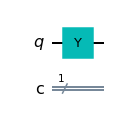

In [8]:
circ = QuantumCircuit(1, 1)
circ.y(0)

transpile(circ).draw('mpl')

# Bell State Measurement and Teleportation

In [9]:
# Bob performs Bell State Measurement
bell_state_measurement = QuantumCircuit(qregister, cregister)

bell_state_measurement.cx(1, 2)
bell_state_measurement.h(1)
# bell_state_measurement.barrier((1, 2))
# bell_state_measurement.measure((1 , 2), (1, 2))

#bell_state_measurement.x(4).c_if(3, 1)
#bell_state_measurement.z(4).c_if(2, 1) # Implement if c_if is possible

# bell_state_measurement.cx(2, 3)
# bell_state_measurement.cz(1, 3) # Implement if c_if is not possible
bell_state_measurement.barrier(range(4))
# bell_state_measurement.draw('mpl')

# Create CHSH3 Bell Test

In [10]:
# Create CHSH3 Bell Test
chsh3test = []

In [11]:
rotate_az_cDzx = QuantumCircuit(qregister, cregister)
rotate_az_cDzx.ry(-np.pi/4, 3)
chsh3test.append(rotate_az_cDzx)

rotate_az_cEzx = QuantumCircuit(qregister, cregister)
rotate_az_cEzx.ry(np.pi/4, 3)
chsh3test.append(rotate_az_cEzx)

rotate_ax_cDzx = QuantumCircuit(qregister, cregister)
rotate_ax_cDzx.ry(-np.pi/2, 0)
rotate_ax_cDzx.ry(-np.pi/4, 3)
chsh3test.append(rotate_ax_cDzx)

rotate_ax_cEzx = QuantumCircuit(qregister, cregister)
rotate_ax_cEzx.ry(-np.pi/2, 0)
rotate_ax_cEzx.ry(np.pi/4, 3)
chsh3test.append(rotate_ax_cEzx)

In [12]:
rotate_az_cDzy = QuantumCircuit(qregister, cregister)
rotate_az_cDzy.rx(np.pi/4, 3)
chsh3test.append(rotate_az_cDzy)

rotate_az_cEzy = QuantumCircuit(qregister, cregister)
rotate_az_cEzy.rx(-np.pi/4, 3)
chsh3test.append(rotate_az_cEzy)

rotate_ay_cDzy = QuantumCircuit(qregister, cregister)
rotate_ay_cDzy.rx(np.pi/2, 0)
rotate_ay_cDzy.rx(np.pi/4, 3)
chsh3test.append(rotate_ay_cDzy)

rotate_ay_cEzy = QuantumCircuit(qregister, cregister)
rotate_ay_cEzy.rx(np.pi/2, 0)
rotate_ay_cEzy.rx(-np.pi/4, 3)
chsh3test.append(rotate_ay_cEzy)

In [13]:
rotate_ax_cDxy = QuantumCircuit(qregister, cregister)
rotate_ax_cDxy.ry(-np.pi/2, 0)
rotate_ax_cDxy.rz(-np.pi/4, 3)
rotate_ax_cDxy.ry(-np.pi/2, 3)
chsh3test.append(rotate_ax_cDxy)

rotate_ax_cExy = QuantumCircuit(qregister, cregister)
rotate_ax_cExy.ry(-np.pi/2, 0)
rotate_ax_cExy.rz(np.pi/4, 3)
rotate_ax_cExy.ry(-np.pi/2, 3)
chsh3test.append(rotate_ax_cExy)

rotate_ay_cDxy = QuantumCircuit(qregister, cregister)
rotate_ay_cDxy.rx(np.pi/2, 0)
rotate_ay_cDxy.rz(-np.pi/4, 3)
rotate_ay_cDxy.ry(-np.pi/2, 3)
chsh3test.append(rotate_ay_cDxy)

rotate_ay_cExy = QuantumCircuit(qregister, cregister)
rotate_ay_cExy.rx(np.pi/2, 0)
rotate_ay_cExy.rz(np.pi/4, 3)
rotate_ay_cExy.ry(-np.pi/2, 3)
chsh3test.append(rotate_ay_cExy)

In [14]:
# chsh3test[0].draw('mpl')

# Perform Measurement of Alice and Charlie

In [15]:
# Measure Alice and Charlie's Qubits
measurement = QuantumCircuit(qregister, cregister)
measurement.barrier(range(4))
measurement.measure((0, 1, 2, 3), (0, 1, 2, 3))

In [16]:
#measurement.draw('mpl')

# Combine Individual Complex Bell Test Circuits

In [17]:
#build circuits
chsh3testlen = len(chsh3test)
circuit_experiments = []
for rotation in chsh3test:
    circuit = QuantumCircuit(qregister, cregister)
    circuit.compose(initial_epr, inplace=True)
    circuit.compose(bell_state_measurement, inplace=True)
    circuit.compose(rotation, inplace=True)
    circuit.compose(measurement, inplace=True)
    circuit_experiments.append(circuit)
    

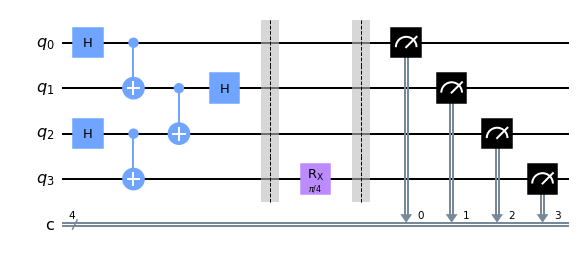

In [18]:
circuit_experiments[4].draw('mpl')

# Create Read Out Error Mitigation Circuits

In [19]:
readoutmitlength = 0
qregistermit = QuantumRegister(4, 'c')
if run_readout_error_mit:
    meas_calibs, state_labels = complete_meas_cal(qr=qregistermit, circlabel='mcal')
    readoutmitlength = len(meas_calibs)
    
    for circ in meas_calibs:
        circuit_experiments.append(circ)


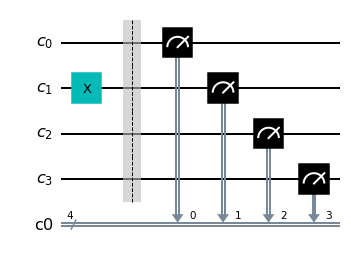

In [20]:
meas_calibs[2].draw('mpl')

# Temporary Modified Circuits for Tomography

In [21]:
qregistertom = QuantumRegister(4, 'q')
cregistertom = ClassicalRegister(2, 'c1')

In [22]:
initial_epr_tom = QuantumCircuit(qregistertom, cregistertom)

initial_epr_tom.h(0)
initial_epr_tom.cx(0, 1)
initial_epr_tom.h(2)
initial_epr_tom.cx(2, 3)

In [23]:
bell_state_measurement_tom = QuantumCircuit(qregistertom, cregistertom)

bell_state_measurement_tom.cx(1, 2)
bell_state_measurement_tom.h(1)
bell_state_measurement_tom.barrier(range(4))

# Create Quantum State Tomography Circuits

In [24]:
# After Bell State Measurement
readoutbsmaftertomlength = 0
if tomography_after_bsm:
    bsm_after = QuantumCircuit(qregistertom, cregistertom)
    bsm_after.compose(initial_epr_tom, inplace=True)
    bsm_after.compose(bell_state_measurement_tom, inplace=True)
    tomography_circuits_after = state_tomography_circuits(bsm_after, [qregistertom[0], qregistertom[3]])
    readoutbsmaftertomlength = len(tomography_circuits_after)
    for circ in tomography_circuits_after:
        circuit_experiments.append(circ)

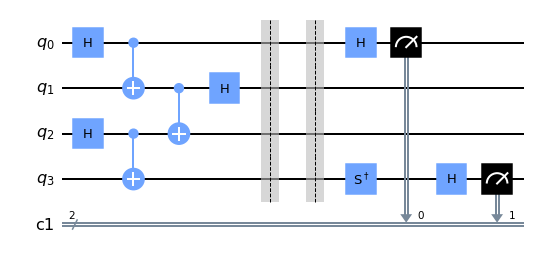

In [25]:
tomography_circuits_after[1].draw('mpl')

In [26]:
# Before Bell State Measurement
readoutbsmbeforetomlength = 0
if tomography_before_bsm:
    qregistertom = QuantumRegister(4, 'q')
    cregistertom = ClassicalRegister(2, 'c2')
    bsm_before = QuantumCircuit(qregistertom, cregistertom)
    bsm_before.compose(initial_epr_tom, inplace=True)
    tomography_circuits_before = state_tomography_circuits(bsm_before, [qregistertom[0], qregistertom[3]])
    readoutbsmbeforetomlength = len(tomography_circuits_before)
    for circ in tomography_circuits_before:
        circuit_experiments.append(circ)

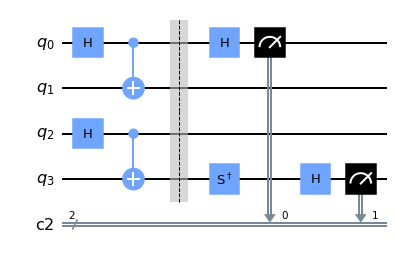

In [27]:
tomography_circuits_before[1].draw('mpl')

# Transpile Circuits to Real Quantum Hardware

In [28]:
transpiled_circuit_exp = transpile(circuit_experiments, ibm_real)
# transpiled_circuit_exp[0].draw('mpl')

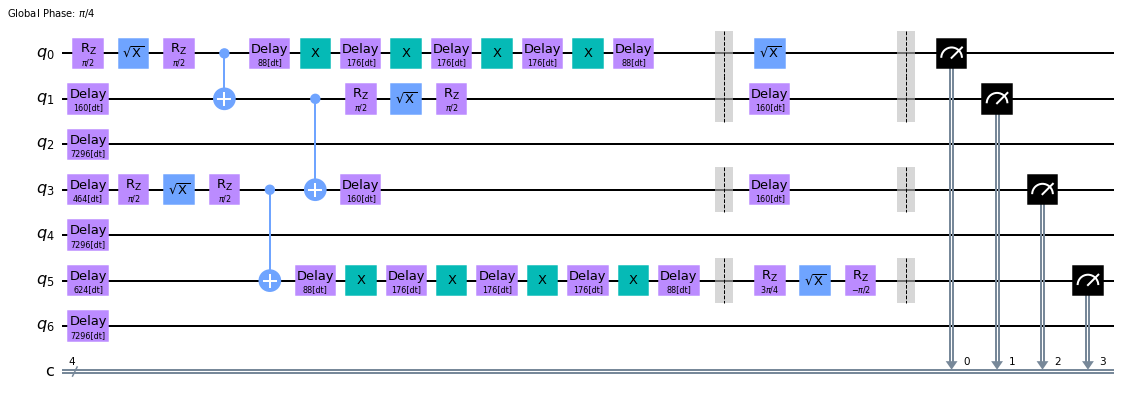

In [29]:
# create instruction durations from the real backend
ID = InstructionDurations()
durations = ID.from_backend(ibm_real)
# balanced X-Y sequence on all qubits
dd_sequence = [XGate(), XGate(), XGate(), XGate()]
pm = PassManager([ALAPScheduleAnalysis(durations),
                  PadDynamicalDecoupling(durations, dd_sequence)])
circ_dd = pm.run(transpile(circuit_experiments[1], ibm_real))
timeline_drawer(circ_dd)

for i in range(len(chsh3test)):
    circ_dd = pm.run(transpile(circuit_experiments[i], ibm_real))
    transpiled_circuit_exp.append(circ_dd)

transpiled_circuit_exp[-1].draw('mpl')

In [30]:
print("Total Circuits in Experiment is | {0} | ~ The max is 100".format(len(transpiled_circuit_exp)))

Total Circuits in Experiment is | 58 | ~ The max is 100


# Run Quantum Circuits

In [ ]:
# Run transpiled circuits on IBM, Simulated IBM, and Perfect IBM Quantum Hardware
ibm_sim_job = ibm_sim.run(transpiled_circuit_exp, shots=10000)
aer_sim_job = aer_sim.run(transpiled_circuit_exp, shots=10000)

if Run_Real and retrieve_ibm_job is None: 
    ibm_real_job = ibm_real.run(transpiled_circuit_exp, shots=20000)
    job_monitor(ibm_real_job)

if retrieve_ibm_job is not None:
    ibm_real_job = ibm_real.retrieve_job(retrieve_ibm_job)

Job Status: job is queued (71)    

In [ ]:
# Grab the results from the job.
aer_sim_result = aer_sim_job.result()
ibm_sim_result = ibm_sim_job.result()
if Run_Real:
    ibm_real_result = ibm_real_job.result()

# Perfect Results For Tomography

In [ ]:
# State Before Circuit
before = QuantumCircuit(4,4)
before

# Individual Results

In [ ]:
ibm_sim_chsh3 = copy.deepcopy(ibm_sim_result)
ibm_sim_chsh3.results = ibm_sim_chsh3.results[0: chsh3testlen]
aer_sim_chsh3 = copy.deepcopy(aer_sim_result)
aer_sim_chsh3.results = aer_sim_chsh3.results[0: chsh3testlen]

ibm_sim_meascalib = copy.deepcopy(ibm_sim_result)
ibm_sim_meascalib.results = ibm_sim_meascalib.results[chsh3testlen: chsh3testlen + readoutmitlength]
aer_sim_meascalib = copy.deepcopy(aer_sim_result)
aer_sim_meascalib.results = aer_sim_meascalib.results[chsh3testlen: chsh3testlen + readoutmitlength]

ibm_sim_bsmafter = copy.deepcopy(ibm_sim_result)
ibm_sim_bsmafter.results = ibm_sim_bsmafter.results[chsh3testlen + readoutmitlength: chsh3testlen + readoutmitlength +readoutbsmaftertomlength]
aer_sim_bsmafter = copy.deepcopy(aer_sim_result)
aer_sim_bsmafter.results = aer_sim_bsmafter.results[chsh3testlen + readoutmitlength: chsh3testlen + readoutmitlength + readoutbsmaftertomlength]

ibm_sim_bsmbefore = copy.deepcopy(ibm_sim_result)
ibm_sim_bsmbefore.results = ibm_sim_bsmbefore.results[chsh3testlen + readoutmitlength: chsh3testlen + readoutmitlength + readoutbsmaftertomlength]
aer_sim_bsmbefore = copy.deepcopy(aer_sim_result)
aer_sim_bsmbefore.results = aer_sim_bsmbefore.results[chsh3testlen + readoutmitlength: chsh3testlen + readoutmitlength + readoutbsmaftertomlength]

ibm_sim_chsh3dd = copy.deepcopy(ibm_sim_result)
ibm_sim_chsh3dd.results = ibm_sim_chsh3.results[chsh3testlen + readoutmitlength + readoutbsmaftertomlength:
                                                chsh3testlen + readoutmitlength + readoutbsmaftertomlength + chsh3testlen]
aer_sim_chsh3dd = copy.deepcopy(aer_sim_result)
aer_sim_chsh3dd.results = aer_sim_chsh3.results[chsh3testlen + readoutmitlength + readoutbsmaftertomlength:
                                                chsh3testlen + readoutmitlength + readoutbsmaftertomlength + chsh3testlen]

if Run_Real:
    ibm_real_chsh3 = copy.deepcopy(ibm_real_result)
    ibm_real_chsh3.results = ibm_real_chsh3.results[0: chsh3testlen]

    ibm_real_meascalib = copy.deepcopy(ibm_real_result)
    ibm_real_meascalib.results = ibm_real_meascalib.results[chsh3testlen: chsh3testlen + readoutmitlength]
    
    ibm_real_bsmafter = copy.deepcopy(ibm_real_result)
    ibm_real_bsmafter.results = ibm_real_bsmafter.results[chsh3testlen + readoutmitlength: chsh3testlen + readoutmitlength + readoutbsmaftertomlength]
    
    ibm_real_bsmbefore = copy.deepcopy(ibm_real_result)
    ibm_real_bsmbefore.results = ibm_real_bsmbefore.results[chsh3testlen + readoutmitlength: chsh3testlen + readoutmitlength + readoutbsmaftertomlength]
    
    ibm_real_chsh3dd = copy.deepcopy(ibm_real_result)
    ibm_real_chsh3dd.results = ibm_real_chsh3.results[chsh3testlen + readoutmitlength + readoutbsmaftertomlength:
                                                      chsh3testlen + readoutmitlength + readoutbsmaftertomlength + chsh3testlen]

# Create Read Out Error Fitter

In [ ]:
# Create Meas Fitter
ibm_sim_meas_fitter = CompleteMeasFitter(ibm_sim_meascalib, state_labels, circlabel='mcal')
aer_sim_meas_fitter = CompleteMeasFitter(aer_sim_meascalib, state_labels, circlabel='mcal')

if Run_Real: 
    ibm_real_meas_fitter = CompleteMeasFitter(ibm_real_meascalib, state_labels, circlabel='mcal')

In [ ]:
# array_to_latex(ibm_sim_meas_fitter.cal_matrix)

In [ ]:
ibm_sim_meas_filter = ibm_sim_meas_fitter.filter
aer_sim_meas_filter = aer_sim_meas_fitter.filter

# Results with mitigation
ibm_sim_chsh3_mitigated = ibm_sim_meas_filter.apply(ibm_sim_chsh3)
aer_sim_chsh3_mitigated = aer_sim_meas_filter.apply(aer_sim_chsh3)

ibm_sim_chsh3dd_mitigated = ibm_sim_meas_filter.apply(ibm_sim_chsh3dd)
aer_sim_chsh3dd_mitigated = aer_sim_meas_filter.apply(aer_sim_chsh3dd)

if Run_Real:
    ibm_real_meas_filter = ibm_sim_meas_fitter.filter
    ibm_real_chsh3_mitigated = ibm_real_meas_filter.apply(ibm_real_chsh3)
    ibm_real_chsh3dd_mitigated = ibm_real_meas_filter.apply(ibm_real_chsh3dd)

# Quantum Tomography Fit

In [ ]:
ibm_sim_bsm_after = StateTomographyFitter(ibm_sim_bsmafter, tomography_circuits_after)
aer_sim_bsm_after = StateTomographyFitter(aer_sim_bsmafter, tomography_circuits_after)

ibm_sim_bsm_before = StateTomographyFitter(ibm_sim_bsmbefore, tomography_circuits_before)
aer_sim_bsm_before = StateTomographyFitter(aer_sim_bsmbefore, tomography_circuits_before)

if Run_Real:
    ibm_real_bsm_after = StateTomographyFitter(ibm_real_bsmafter, tomography_circuits_after)
    ibm_real_bsm_before = StateTomographyFitter(ibm_real_bsmbefore, tomography_circuits_before)

# CHSH Calculations

In [ ]:
def calc_chsh1(theta_dict):
    zz = theta_dict[0]
    zx = theta_dict[1]
    xz = theta_dict[3]
    xx = theta_dict[2]
    
    no_shots = sum(xx[y] for y in xx)

    chsh = 0
    totalOO = 0

    for element in zz:
        if (int(element[1]) == 0 and int(element[2]) == 0):
            totalOO += zz[element]
            parity = (-1)**(int(element[0])+int(element[3]))
            chsh += parity*zz[element]
        
    for element in zx:
        if (int(element[1]) == 0 and int(element[2]) == 0):
            totalOO += zx[element]
            parity = (-1)**(int(element[0])+int(element[3]))
            chsh += parity*zx[element]

    for element in xz:
        if (int(element[1]) == 0 and int(element[2]) == 0):
            totalOO += xz[element]
            parity = (-1)**(int(element[0])+int(element[3]))
            chsh -= parity*xz[element]

    for element in xx:
        if (int(element[1]) == 0 and int(element[2]) == 0):
            totalOO += xx[element]
            parity = (-1)**(int(element[0])+int(element[3]))
            chsh += parity*xx[element]
    
    return 4*chsh / totalOO

In [ ]:
def calc_chsh23(theta_dict):
    zz = theta_dict[0]
    zx = theta_dict[1]
    xz = theta_dict[2]
    xx = theta_dict[3]
    
    no_shots = sum(xx[y] for y in xx)

    chsh = 0
    totalOO = 0

    for element in zz:
        if (int(element[1]) == 0 and int(element[2]) == 0):
            totalOO += zz[element]
            parity = (-1)**(int(element[0])+int(element[3]))
            chsh += parity*zz[element]

    for element in zx:
        if (int(element[1]) == 0 and int(element[2]) == 0):
            totalOO += zx[element]
            parity = (-1)**(int(element[0])+int(element[3]))
            chsh += parity*zx[element]

    for element in xz:
        if (int(element[1]) == 0 and int(element[2]) == 0):
            totalOO += xz[element]
            parity = (-1)**(int(element[0])+int(element[3]))
            chsh -= parity*xz[element]

    for element in xx:
        if (int(element[1]) == 0 and int(element[2]) == 0):
            totalOO += xx[element]
            parity = (-1)**(int(element[0])+int(element[3]))
            chsh += parity*xx[element]
    
    return 4*chsh / totalOO

In [ ]:
def get_chsh3(circuit_counts):
    chsh23 = calc_chsh23(circuit_counts[8:12]) + calc_chsh23(circuit_counts[4:8])
    chsh1 = calc_chsh1(circuit_counts[0:4])
    return chsh23 + chsh1

# Probability of EPR Pairs

In [ ]:
def prob_epr_pairs(circuit_counts):
    no_shots = sum(circuit_counts[outcome] for outcome in circuit_counts)
    
    zz = 0
    zo = 0
    oz = 0
    oo = 0
    
    for element in circuit_counts:
        if int(element[0]) == 0 and int(element[3]) == 0:
            zz += circuit_counts[element]
            
        if int(element[0]) == 0 and int(element[3]) == 1:
            zo += circuit_counts[element]
            
        if int(element[0]) == 1 and int(element[3]) == 0:
            oz += circuit_counts[element]
            
        if int(element[0]) == 1 and int(element[3]) == 1:
            oo += circuit_counts[element]
            
    return np.array([zz, zo, oz, oo]) / no_shots

# Tomography Calculations

In [ ]:
ibm_sim_bsm_after = ibm_sim_bsm_after.fit(method='lstsq')
ibm_sim_bsm_before = ibm_sim_bsm_before.fit(method='lstsq')

aer_sim_bsm_after = aer_sim_bsm_after.fit(method='lstsq')
aer_sim_bsm_before = aer_sim_bsm_before.fit(method='lstsq')

if Run_Real:
    ibm_real_bsm_after = ibm_real_bsm_after.fit(method='lstsq')
    ibm_real_bsm_before = ibm_real_bsm_before.fit(method='lstsq')

# Complex Bell Test Results

In [ ]:
print("Complex Bell Test")
print("Manila Sim Results: {0:.4f}".format(get_chsh3(ibm_sim_chsh3.get_counts())))
print("Manila Sim Mitigated Results: {0:.4f}".format(get_chsh3(ibm_sim_chsh3_mitigated.get_counts())))
print("Manila Sim DD Mitigated Results: {0:.4f}".format(get_chsh3(ibm_sim_chsh3dd_mitigated.get_counts())))

if Run_Real:
    print("Manila Real Results: {0:.4f}".format(get_chsh3(ibm_real_chsh3.get_counts())))
    print("Manila Real Mitigated Results: {0:.4f}".format(get_chsh3(ibm_real_chsh3_mitigated.get_counts())))
    print("Manila Real DD Mitigated Results: {0:.4f}".format(get_chsh3(ibm_real_chsh3dd_mitigated.get_counts())))
    
print("Aer Sim Results: {0:.7f}".format(get_chsh3(aer_sim_chsh3.get_counts())))
print("Aer Sim Mitigated Results: {0:.7f}".format(get_chsh3(aer_sim_chsh3_mitigated.get_counts())))
print("Quantum Theoretical: ")
print(6*np.sqrt(2))

In [ ]:
plot_histogram(ibm_sim_chsh3.get_counts()[-1])

In [ ]:
plot_histogram(ibm_sim_chsh3_mitigated.get_counts()[-1])

In [ ]:
# if Run_Real: 
plot_histogram(ibm_real_chsh3.get_counts()[-1])

In [ ]:
# if Run_Real: 
plot_histogram(ibm_real_chsh3_mitigated.get_counts()[-1])

In [ ]:
plot_histogram(aer_sim_chsh3.get_counts()[-1])

In [ ]:
plot_histogram(aer_sim_chsh3_mitigated.get_counts()[-1])

# Tomography Results

In [ ]:
print('State fidelity IBM Sim BSM After: F = {:.5f}'.format(qi.state_fidelity(
    ibm_sim_bsm_after, partial_trace(DensityMatrix(bsm_after),[0,3]))))

In [ ]:
plot_state_city(ibm_sim_bsm_after)

In [ ]:
print('State fidelity IBM Sim BSM Before: F = {:.5f}'.format(qi.state_fidelity(
    ibm_sim_bsm_before, partial_trace(DensityMatrix(bsm_before),[0,3]))))

In [ ]:
plot_state_city(ibm_sim_bsm_before)

In [ ]:
print('State fidelity IBM Real BSM After: F = {:.5f}'.format(qi.state_fidelity(
    ibm_real_bsm_after, partial_trace(DensityMatrix(bsm_after),[0,3]))))

In [ ]:
plot_state_city(ibm_real_bsm_after)

In [ ]:
print('State fidelity IBM Real BSM Before: F = {:.5f}'.format(qi.state_fidelity(
    ibm_real_bsm_before, partial_trace(DensityMatrix(bsm_before),[0,3]))))

In [ ]:
plot_state_city(ibm_real_bsm_before)

In [ ]:
print('State fidelity Aer Sim BSM After: F = {:.5f}'.format(qi.state_fidelity(
    aer_sim_bsm_after, partial_trace(DensityMatrix(bsm_after),[1,2]))))

In [ ]:
plot_state_city(aer_sim_bsm_after)

In [ ]:
print('State fidelity Aer Sim BSM After: F = {:.5f}'.format(qi.state_fidelity(
    aer_sim_bsm_before, partial_trace(DensityMatrix(bsm_before),[1,2]))))

In [ ]:
plot_state_city(aer_sim_bsm_before)